# Classifying Images with a Convolutional Neural Net

**Samantha Papadakis | 9/16/2022**

This notebook will train a convolutional neural network (CNN) to classify images from the CIFAR-10 image data set. Which model architecture will result in the highest accuracy?

### Hypothesis:
The CNN model with the greatest number of parameters of the tested options (3 convolutional layers, with [16, 32, 64] kernels per layer, and 2 dense layers) will be the most accurate.

## Import dependencies

In [1]:
%%capture
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## The images used for this analysis come from the CIFAR-10 data set

[This data set](https://keras.io/api/datasets/cifar10/) contains 50,000 training images and 10,000 test images. These color images are 32x32 pixels in size. The images are labeled over 10 categories:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck


## Load the data set

In [2]:
# Load the data and split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# https://keras.io/api/datasets/cifar10/

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

# Convert vectors to matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


50000 train samples
10000 test samples


## Reduce the sample size to decrease model run time

CNN models run faster when there are fewer input images. Shorter run times and lower resource loads are useful when running models on devices with limited processing capabilities, like a small laptop. However, larger sample sizes improve learning and lead to greater model accuracy, so reducing the sample size could impact model performance.

Instead of decreasing the number of images per class in this data set, a better approach would be to reduce the number of classes. The training set has 10 classes with 5,000 images per class, yielding a total of 50,000 images. Reducing the number of classes from 10 down to 3 will cut the sample by 70% while maintaining the maximum number of available images per class.

The three classes that will be retained for this project are **horse, ship,** and **truck.** These classes were chosen because they contain distinct features that may help differentiate the images, such as horizontal lines for trucks and blue pixels for ships in water. Strongly differentiated features are especially useful given the low resolution of the 32 x 32 pixel images.

Images from these three classes will be selected from the full sample, below.

In [3]:
# First, see what the structure of the variable containing the class identifiers, y_train, looks like.
y_train[0:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [4]:
# Horse, Ship, and Truck are identified by a "1" in the 8th, 9th, and 10th columns, or indices 7, 8, 9.
# Make a list of indices for images identified as the desired classes

img_idx = [i for i in range(len(y_train)) if
            y_train[i][7] == 1 or
            y_train[i][8] == 1 or
            y_train[i][9] == 1]

print("The new sample has "+str(len(img_idx))+" images.")

The new sample has 15000 images.


In [5]:
# Select a subsample of x_train and y_train based on the indices identified above.

x_train_3c = x_train[img_idx]
y_train_3c_10col = y_train[img_idx]

# y_train still has 10 "columns" for classes, so remove the first unused 7 indices:
y_train_3c_list = [y_train_3c_10col[i][7:10] for i in range(len(y_train_3c_10col))]
y_train_3c = np.array(y_train_3c_list)

In [6]:
# Repeat the proceduce for the test sets.

img_idx_test = [i for i in range(len(y_test)) if
            y_test[i][7] == 1 or
            y_test[i][8] == 1 or
            y_test[i][9] == 1]

x_test_3c_255 = x_test[img_idx_test]
# Convert the 255-based color values to a scale of 0-1
# The pixel color values of the x_train images are adjusted during augmentation 
x_test_3c = x_test_3c_255/255.0

y_test_3c_10col = y_test[img_idx_test]
y_test_3c_list = [y_test_3c_10col[i][7:10] for i in range(len(y_test_3c_10col))]
y_test_3c = np.array(y_test_3c_list)

print("The new test sample has "+str(len(img_idx_test))+" images.")

The new test sample has 3000 images.


## Image Augmentation: Introduce random changes to increase the variety of image features

If every image of a horse in the training data set was standing right-side up, then the model might not be able to accurately identify a new image of a horse that happens to be upside-down. To increase the generlizability of the model and allow it to work with a wider variety of images, the training set will be randomly augmented.

In [7]:
datagen_train = ImageDataGenerator(
    brightness_range=[0.9, 1.1], ## randomly adjusts image brightness between -10% and +10%, mimics exposure variation
    channel_shift_range=25, ## shifts the color of the image slightly
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,    
    rescale=1./255,
    )

aug_IDG = datagen_train.flow(
    x_train_3c,
    y_train_3c,
    batch_size=1,
    shuffle=False)

## Visualize the augmentations to see the difference in images
Note how the augmented images provide a much greater variety of image features.

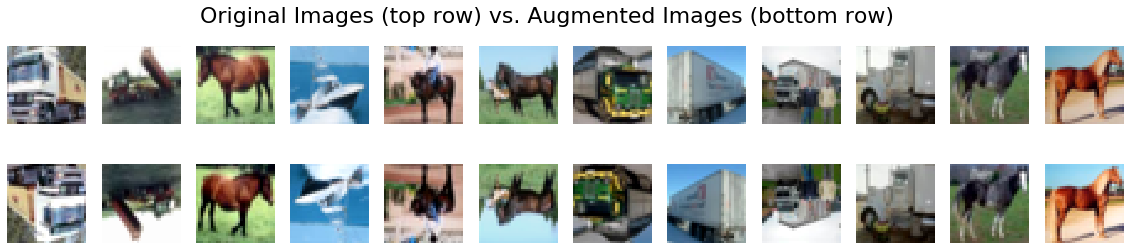

In [9]:
num_test_imgs = 12

fig, ax = plt.subplots(nrows=2, ncols=num_test_imgs, figsize=(20,4))

fig.suptitle('Original Images (top row) vs. Augmented Images (bottom row)', fontsize=22)

for i in range(num_test_imgs):
    ax[0][i].imshow(x_train_3c[i]*(1./255))
    ax[0][i].axis('off')
    
    ax[1][i].imshow(aug_IDG[i][0][0])
    ax[1][i].axis('off')

# Which model architecture will classify the images with the greatest accuracy?

Let's see if model accuracy can be improved by changing the:
* Number of convolutional layers:
    - 1 layers
    - 2 layers
    - 3 layers
* Number of kernels per convolutional layer:
    - 4, 8, 16 kernels for layers 1, 2, and 3, respectively
    - 8, 16, 32
    - 16, 32, 64
* Number of dense layers:
    - 1 dense layer
    - 2 dense layers

This will yield a total of **18 different model architectures.**

## Run the model combinations

In [10]:
### SETUP MODEL PARAMETERS ###

### Standard parameters
batch_size = 64
epochs = 200
lr = 0.05
label_smoothing = 0.0
num_classes=3

### Different Model Architecture parameters to try

#num_layers specifies the number of convolutional layers
num_layers = [1,2,3]
#num_kernels_lay1 specifies the number of kernels, or feature-detecting filters, in the first layer
num_kernels_lay1 = [4, 8, 16]
#kern_multiplier will help determine the number of kernels in subsequent layers
kern_multiplier = [1, 2, 4]
#dense2 specifies the number of dense layers
dense2 = [1, 2]

in_dim = 32
num_channels = 3
input_shape = (in_dim, in_dim, num_channels)
acc_track = []
results_track = []

In [11]:
## SETUP DATA SETS ##

### Augment the Images with the full batch size
aug_IDG = datagen_train.flow(
    x_train_3c,
    y_train_3c,
    batch_size=batch_size,
    shuffle=True)

### Extract the augmented training data sets
aug_IDG.reset()
aug_x_train, aug_y_train = next(aug_IDG)
for i in range(int(len(aug_IDG)-1)):
    img, label = next(aug_IDG)
    aug_x_train = np.append(aug_x_train, img, axis=0 )
    aug_y_train = np.append(aug_y_train, label, axis=0)

In [ ]:
## RUN 18 MODELS ##

for d in dense2:
    for i in num_layers:
        for j in num_kernels_lay1:
            
            tf.keras.backend.clear_session()
            tf.reset_default_graph()
            
            ds_train = tf.data.Dataset.from_tensor_slices((aug_x_train, aug_y_train))
            ds_valid = tf.data.Dataset.from_tensor_slices((x_test_3c, y_test_3c))

            ds_train = ds_train.batch(batch_size)
            ds_valid = ds_valid.batch(batch_size)
            
            
            ### Use Early Stopping to end early if the loss has already reached its minimum
            
            # End if loss has not improved (decreased) after 20 epochs
            patience = 20
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                 restore_best_weights=True)

            ### Declare the Optimizer and Loss to use
            
            optimizer = SGD(lr=0.001, momentum=0.9)
            loss = tf.keras.losses.CategoricalCrossentropy(
                from_logits=True,
                label_smoothing=label_smoothing)
            
            
            ### Prepare for a Second Dense Layer
            
            n_layers = i
            n_last_channels = j * kern_multiplier[i-1]
            # size of image in last convolution layer
            last_channel_size = int(in_dim/(2**n_layers))**2
            # number of units in first dense layer
            dense_size = n_last_channels*last_channel_size

            ### Set up model architechture
            
            model = keras.Sequential()
            model.add(keras.Input(shape=input_shape))
            
            for con_lay in range(i):
                ## Start with a layer that performs convolution
                model.add(layers.Conv2D(filters=j*kern_multiplier[con_lay],
                                        kernel_size = (3,3),
                                        padding='same',
                                        activation='relu',
                                        kernel_initializer='he_uniform'))
                ## Perform batch normalization to stabilize learning
                model.add(layers.BatchNormalization())
                ## Add a layer that condenses the feature by selecting the maximum value from every 2x2 region 
                model.add(layers.MaxPooling2D((2,2)))
                ## Perform regularization by randomly dropping 20% of the nodes from the network
                model.add(layers.Dropout(0.2))

            model.add(layers.Flatten())
                
            if d==2:
                model.add(layers.Dense(j*kern_multiplier[i-1], activation='relu', kernel_initializer='he_uniform',
                                       input_shape=(dense_size,)))
                model.add(layers.Dropout(0.75))
                
            model.add(layers.Dense(num_classes,activation='softmax'))

            
            ### Compile model
            
            model.compile(
                loss=loss,
                optimizer=optimizer,
                metrics=["accuracy"],
                run_eagerly=False)
                
            
            ### Run model
            
            results_history = model.fit(
                ds_train,
                epochs=epochs,
                shuffle=True,
                validation_data=ds_valid,
                callbacks=[early_stopping])

            ### Evaluate model on x_test & y_test and store performance metrics
            
            test_results = model.evaluate(x_test_3c, y_test_3c)
            acc_track.append([i, j, d, test_results[1], test_results[0]])
            results_track.append([i, j, d, results_history.history])
            
            ### Reset model/graph
            tf.keras.backend.clear_session()
            tf.reset_default_graph()


## Which combination had the greatest accuracy?

In [13]:
acc_df = pd.DataFrame(acc_track, columns = ['Num_Conv_Layers', 'Num_Filters_in_Lay1', 'Num_Dense_Layers', 'Accuracy', 'Loss'])

maxidx = acc_df['Accuracy'].idxmax()

print("The most accurate model was comprised of", acc_df['Num_Conv_Layers'].iloc[maxidx], "convolutional layers, with",
      acc_df['Num_Filters_in_Lay1'].iloc[maxidx], "kernels in the first layer and",
      acc_df['Num_Dense_Layers'].iloc[maxidx], "dense layer(s).\n",
      "Accuracy:", round(acc_df['Accuracy'].iloc[maxidx]*100, 1), "%\n",
      "Loss:", round(acc_df['Loss'].iloc[maxidx],4))


The most accurate model was comprised of 2 convolutional layers, with 16 kernels in the first layer and 1 dense layer(s).
 Accuracy: 86.6 %
 Loss: 0.6799


## Visualize the Accuracy Levels for the different model architectures

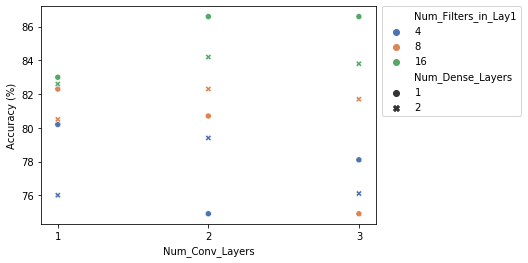

In [14]:
acc_df['Num_Conv_Layers'] = acc_df.Num_Conv_Layers.astype(str)
acc_df['Accuracy (%)'] = round(acc_df['Accuracy']*100,1)
sns.scatterplot(data=acc_df, x="Num_Conv_Layers", y="Accuracy (%)", hue="Num_Filters_in_Lay1",
                style="Num_Dense_Layers", palette = 'deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Conclusion

After augmenting the images from the CIFAR10 data set to increase variability in the data set, the model architecture that achieved the greatest accuracy when classifying the images had:
* 2 convolutional layers
* 16, 32, 64 kernels in each convolutional layer, respectively
* 1 dense layer

This model was 86.6% accurate and is well-suited for classifying new images.

### Hypothesis refuted: the largest model was not the most accurate. Why?
When evaluating the trends of the accuracy plot above, it becomes clear that adding a third layer -- while holding the number of kernels in layer 1 and number of dense layers constant -- leads to a slight decrease in accuracy for all model architectures except the smallest one (4 kernels in layer 1 with 1 dense layer). While this result did not support the hypothesis, it may indicate that the larger models are **overfitting** the data.

Increasing the number of layers, as well as the number of kernels, increases the number of features that are detected in the image. This is useful up to a point. Once all of the identifying features of an object have been detected, continuing to force the model to learn to detect more features might result in it focusing on irrelevant features in the image.

For example, some of the "horse" images in this data set included a person. If the model learned all of the features that identified a horse, then adding more kernels could lead the model to pick up on the features of the person. Then, if an image of a truck happened to have a person standing in front, the model might recognize the abundance of human features and classify the image with the label, "horse."

Thus, it is possible that these low-resolution images (only 36 x 36 pixels in size) may have had a small number of distinguishing features to begin with, making the data highly vulnerable to **overfitting.**

### Visually confirm the performance for the best model
It is useful to check that the loss decreased with each epoch until reaching a low plateau. A resurgence in loss may indicate overfitting.

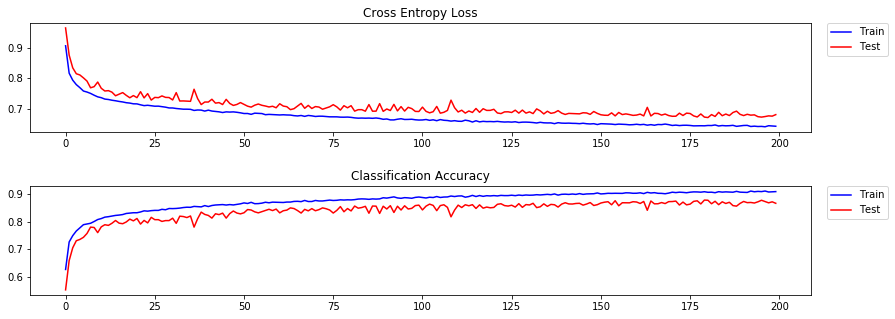

In [15]:
results_df = pd.DataFrame(results_track, columns = ['Num_Conv_Layers', 'Num_Filters_in_Lay1', 'Num_Dense_Layers', 'Results'])

### Manually set the following labels to the values of the best model:
best_mod = results_df.query('Num_Conv_Layers==2 and Num_Filters_in_Lay1==16 and Num_Dense_Layers==1')['Results']
best_mod = best_mod.iloc[0]

plt.rcParams['figure.figsize'] = [14, 5]
plt.subplots_adjust(hspace=0.5)

# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(best_mod['loss'], color='blue', label='Train')
plt.plot(best_mod['val_loss'], color='red', label='Test')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(best_mod['acc'], color='blue', label='Train')
plt.plot(best_mod['val_acc'], color='red', label='Test')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

The loss during validation ("test") followed the expected trajectory of decreasing until a plateau, adding confidence that the model is well-suited for classification on this data set.


### Future Directions for model optimization
Given that the loss was continuing to improve until the final epoch (200), future optimization efforts should include running the model for more epochs until a true plateau emerges. Additionally, given the trends of the earlier accuracy comparison plot, it may be worthwhile to test whether a greater number of initial kernels in layer one (e.g. 32 kernels instead of 16) would continue to improve model performance.